已连接到 env-zqh (Python 3.11.0)

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 5670


<ipython-input-1-1099f27baed2>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-1-1099f27baed2>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[1] Reject
[2] Reject
[3] Accept | Loss = 1.793302 -> 1.058043 | parameter #: 5670| time: 641.4622802734375
[4] Accept | Loss = 1.058043 -> 0.988683 | parameter #: 5670| time: 894.403564453125
[5] Accept | Loss = 0.988683 -> 0.975670 | parameter #: 5670| time: 1152.6533203125
[6] Accept | Loss = 0.975670 -> 0.953683 | parameter #: 5670| time: 1408.79052734375
[7] Accept | Loss = 0.953683 -> 0.910184 | parameter #: 5670| time: 1673.639892578125
[8] Accept | Loss = 0.910184 -> 0.819100 | parameter #: 5670| time: 1935.205322265625
[9] Reject
[10] Accept | Loss = 0.819100 -> 0.712193 | parameter #: 5670| time: 2467.3720703125
[11] Reject
[12] Accept | Loss = 0.712193 -> 0.634676 | parameter #: 5670| time: 2994.1103515625
[13] Accept | Loss = 0.634676 -> 0.531374 | parameter #: 5670| time: 3251.82568359375
[14] Reject
[15] Accept | Loss = 0.531374 -> 0.470252 | parameter #: 5670| time: 3800.65576171875
[16] Accept | Loss = 0.470252 -> 0.418444 | parameter #: 5670| time: 4070.900634765625
[1

<ipython-input-1-1099f27baed2>:103: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647369228/work/aten/src/ATen/native/TensorShape.cpp:3683.)
  correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)


[6] Accept | Loss = 0.994064 -> 0.901506 | parameter #: 5670| time: 1085.3621826171875
[7] Reject
[8] Accept | Loss = 0.901506 -> 0.829425 | parameter #: 5670| time: 1522.881591796875
[9] Accept | Loss = 0.829425 -> 0.686066 | parameter #: 5670| time: 1751.70556640625
[10] Reject
[11] Accept | Loss = 0.686066 -> 0.596847 | parameter #: 5670| time: 2185.1044921875
[12] Reject
[13] Accept | Loss = 0.596847 -> 0.543118 | parameter #: 5670| time: 2600.1171875
[14] Accept | Loss = 0.543118 -> 0.471047 | parameter #: 5670| time: 2809.954345703125
[15] Accept | Loss = 0.471047 -> 0.414649 | parameter #: 5670| time: 3027.5185546875
optnumber 5670
[16] Accept | Loss = 0.414649 -> 0.392308 | parameter #: 5670| time: 3253.045166015625
[17] Accept | Loss = 0.392308 -> 0.380813 | parameter #: 5670| time: 3475.2255859375
[18] Reject
[19] Accept | Loss = 0.380813 -> 0.373976 | parameter #: 5670| time: 3912.109130859375
[20] Accept | Loss = 0.373976 -> 0.364381 | parameter #: 5670| time: 4128.96582031

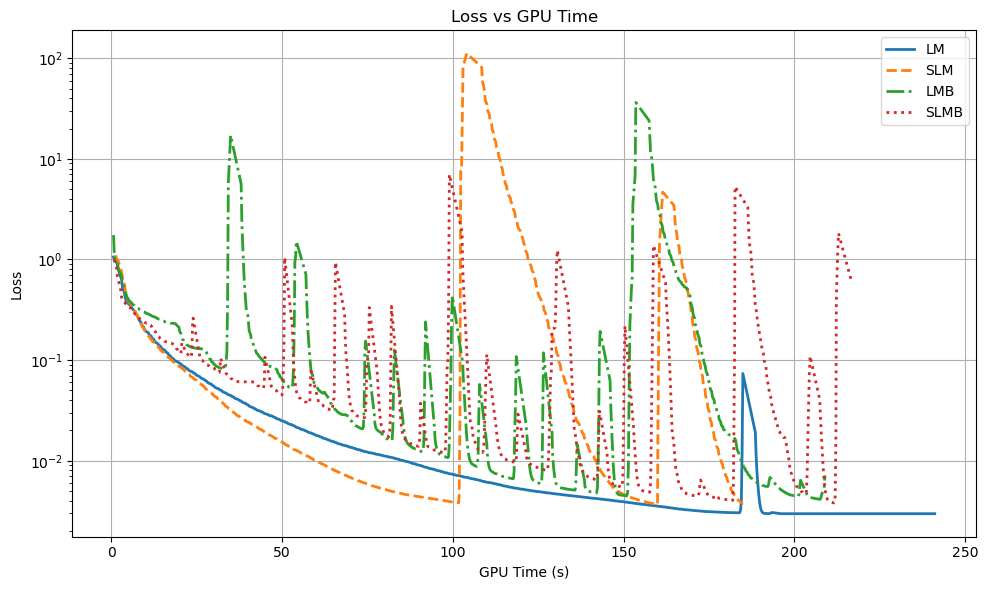

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],70, 70, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=5670, step=1000,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=5670, step=1100,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=5670, step=1100,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=5670, step=1000,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 5670
[1] Reject


<ipython-input-2-1099f27baed2>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-2-1099f27baed2>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[2] Reject
[3] Accept | Loss = 2.447643 -> 1.099865 | parameter #: 5670| time: 289.9558410644531
[4] Accept | Loss = 1.099865 -> 0.976012 | parameter #: 5670| time: 431.1152648925781
[5] Accept | Loss = 0.976012 -> 0.956956 | parameter #: 5670| time: 571.1452026367188
[6] Accept | Loss = 0.956956 -> 0.926116 | parameter #: 5670| time: 713.1043701171875
[7] Accept | Loss = 0.926116 -> 0.865799 | parameter #: 5670| time: 868.642822265625
[8] Accept | Loss = 0.865799 -> 0.744106 | parameter #: 5670| time: 1010.7105102539062
[9] Reject
[10] Accept | Loss = 0.744106 -> 0.622074 | parameter #: 5670| time: 1315.3515625
[11] Reject
[12] Accept | Loss = 0.622074 -> 0.546545 | parameter #: 5670| time: 1600.5478515625
[13] Accept | Loss = 0.546545 -> 0.462124 | parameter #: 5670| time: 1745.259521484375
[14] Reject
[15] Accept | Loss = 0.462124 -> 0.424562 | parameter #: 5670| time: 2029.8004150390625
[16] Accept | Loss = 0.424562 -> 0.397131 | parameter #: 5670| time: 2175.582275390625
[17] Acce

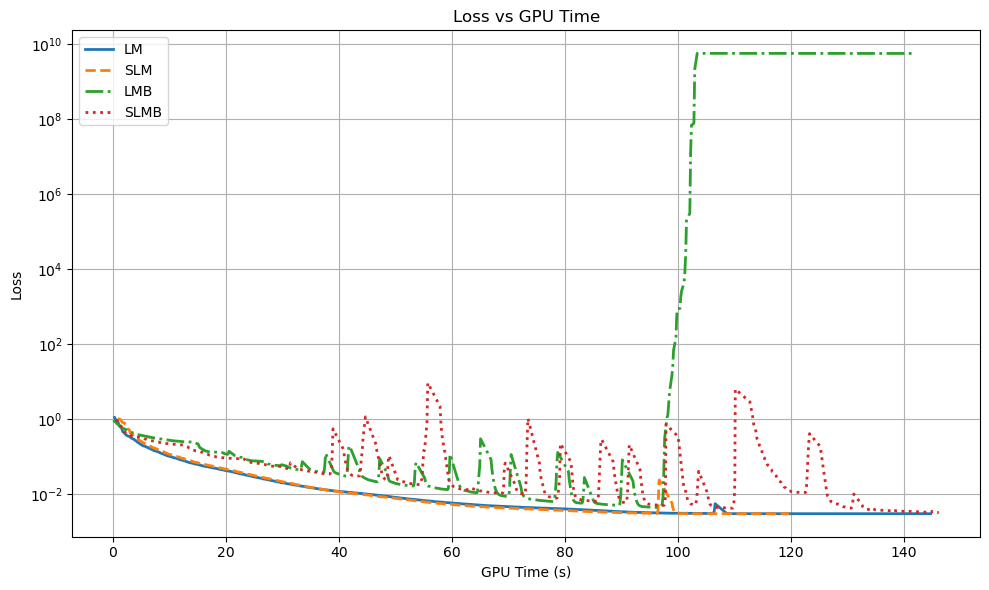

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],70, 70, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=5670, step=1000,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=5670, step=1100,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=5670, step=1100,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=5670, step=1000,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 3050
[1] Accept | Loss = 1.036324 -> 0.986099 | parameter #: 3050| time: 0
[2] Accept | Loss = 0.986099 -> 0.943243 | parameter #: 3050| time: 84.8936996459961


<ipython-input-4-784c7f724b1f>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-4-784c7f724b1f>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[3] Accept | Loss = 0.943243 -> 0.859132 | parameter #: 3050| time: 149.1056671142578
[4] Reject
[5] Accept | Loss = 0.859132 -> 0.754152 | parameter #: 3050| time: 326.93963623046875
[6] Reject
[7] Accept | Loss = 0.754152 -> 0.670675 | parameter #: 3050| time: 507.3602600097656
[8] Accept | Loss = 0.670675 -> 0.555167 | parameter #: 3050| time: 576.3717041015625
[9] Reject
[10] Accept | Loss = 0.555167 -> 0.483439 | parameter #: 3050| time: 742.1040649414062
[11] Accept | Loss = 0.483439 -> 0.424799 | parameter #: 3050| time: 850.107421875
[12] Accept | Loss = 0.424799 -> 0.393434 | parameter #: 3050| time: 974.6647338867188
[13] Accept | Loss = 0.393434 -> 0.370987 | parameter #: 3050| time: 1074.4443359375
[14] Reject
[15] Accept | Loss = 0.370987 -> 0.354498 | parameter #: 3050| time: 1234.9429931640625
[16] Reject
[17] Accept | Loss = 0.354498 -> 0.342740 | parameter #: 3050| time: 1399.700439453125
[18] Accept | Loss = 0.342740 -> 0.322577 | parameter #: 3050| time: 1482.3454589

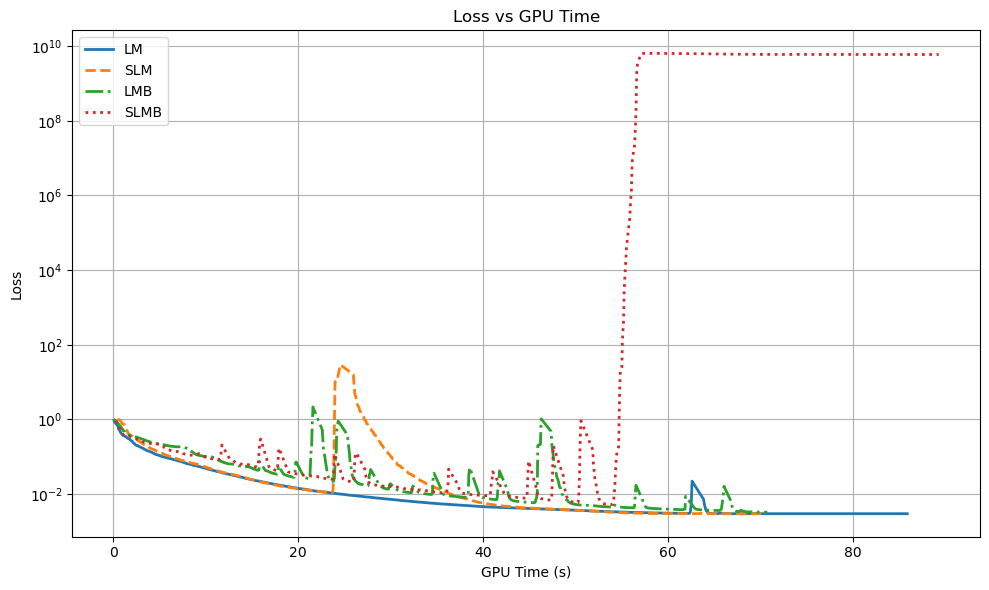

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],50, 50, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    optnum=3050
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=optnum, step=1000,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=optnum, step=1100,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=optnum, step=1100,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=optnum, step=1000,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 3050
[1] Reject
[2] Reject


<ipython-input-5-784c7f724b1f>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-5-784c7f724b1f>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[3] Accept | Loss = 1.506351 -> 1.079154 | parameter #: 3050| time: 173.98681640625
[4] Accept | Loss = 1.079154 -> 1.005329 | parameter #: 3050| time: 245.5715789794922
[5] Accept | Loss = 1.005329 -> 0.987506 | parameter #: 3050| time: 328.07525634765625
[6] Accept | Loss = 0.987506 -> 0.960530 | parameter #: 3050| time: 410.5881652832031
[7] Accept | Loss = 0.960530 -> 0.909494 | parameter #: 3050| time: 470.3795166015625
[8] Accept | Loss = 0.909494 -> 0.808936 | parameter #: 3050| time: 562.0234375
[9] Reject
[10] Accept | Loss = 0.808936 -> 0.699056 | parameter #: 3050| time: 713.439208984375
[11] Reject
[12] Accept | Loss = 0.699056 -> 0.621452 | parameter #: 3050| time: 862.7394409179688
[13] Accept | Loss = 0.621452 -> 0.519308 | parameter #: 3050| time: 965.3851928710938
[14] Reject
[15] Accept | Loss = 0.519308 -> 0.460677 | parameter #: 3050| time: 1097.301025390625
[16] Accept | Loss = 0.460677 -> 0.411105 | parameter #: 3050| time: 1187.4866943359375
[17] Accept | Loss = 

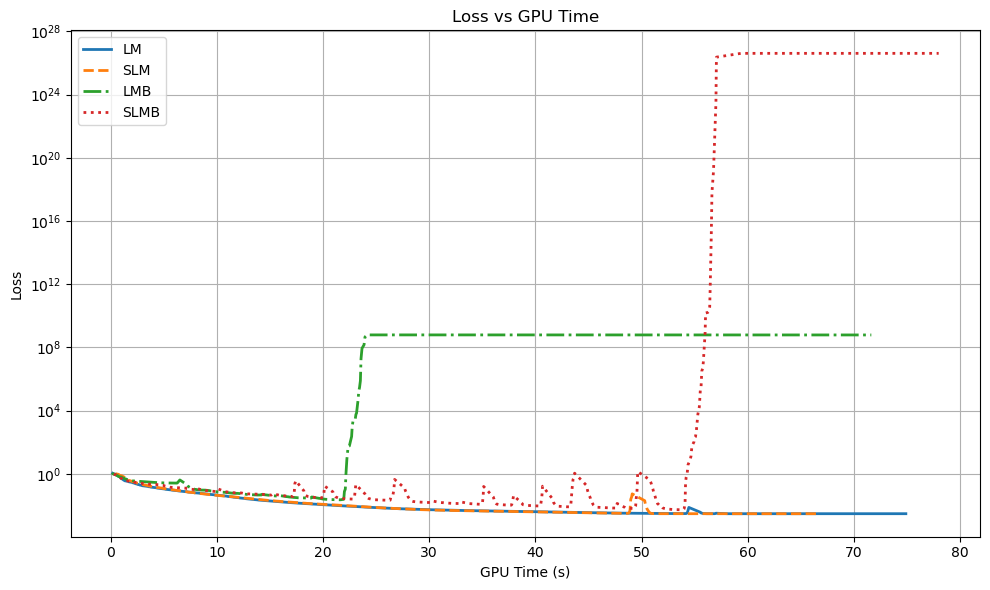

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],50, 50, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    optnum=3050
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=optnum, step=1000,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=optnum, step=1100,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=optnum, step=1100,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=optnum, step=1000,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 3050
[1] Accept | Loss = 1.056620 -> 0.922316 | parameter #: 3050| time: 0
[2] Accept | Loss = 0.922316 -> 0.844368 | parameter #: 3050| time: 50.58662414550781
[3] Reject


<ipython-input-6-06a9923a471c>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-6-06a9923a471c>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[4] Accept | Loss = 0.844368 -> 0.779079 | parameter #: 3050| time: 169.86111450195312
[5] Accept | Loss = 0.779079 -> 0.673328 | parameter #: 3050| time: 229.61561584472656
[6] Reject
[7] Accept | Loss = 0.673328 -> 0.588994 | parameter #: 3050| time: 344.474609375
[8] Accept | Loss = 0.588994 -> 0.489738 | parameter #: 3050| time: 388.64178466796875
[9] Reject
[10] Accept | Loss = 0.489738 -> 0.440667 | parameter #: 3050| time: 489.34808349609375
[11] Accept | Loss = 0.440667 -> 0.400925 | parameter #: 3050| time: 542.36669921875
[12] Accept | Loss = 0.400925 -> 0.372921 | parameter #: 3050| time: 588.19482421875
[13] Reject
[14] Accept | Loss = 0.372921 -> 0.358316 | parameter #: 3050| time: 680.3732299804688
[15] Accept | Loss = 0.358316 -> 0.338527 | parameter #: 3050| time: 727.8817138671875
[16] Reject
[17] Accept | Loss = 0.338527 -> 0.322408 | parameter #: 3050| time: 829.000732421875
[18] Accept | Loss = 0.322408 -> 0.297359 | parameter #: 3050| time: 874.8380126953125
[19] R

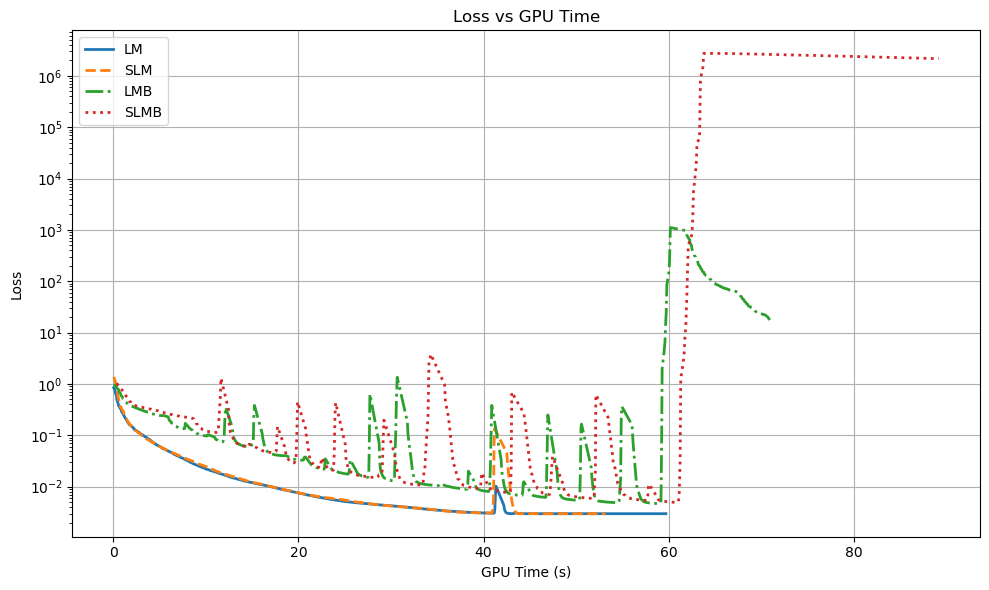

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],50, 50, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    optnum=3050
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=optnum, step=1000,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=optnum, step=1100,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=optnum, step=1100,bd_tol=1,zone=3/4)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=optnum, step=1000,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 3050
[1] Reject
[2] Accept | Loss = 1.144320 -> 1.008100 | parameter #: 3050| time: 77.54035186767578


<ipython-input-7-d86dbf449ac4>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-7-d86dbf449ac4>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[3] Accept | Loss = 1.008100 -> 0.989804 | parameter #: 3050| time: 156.16307067871094
[4] Accept | Loss = 0.989804 -> 0.961743 | parameter #: 3050| time: 220.77337646484375
[5] Accept | Loss = 0.961743 -> 0.907594 | parameter #: 3050| time: 297.1883544921875
[6] Reject
[7] Accept | Loss = 0.907594 -> 0.852955 | parameter #: 3050| time: 437.8941345214844
[8] Accept | Loss = 0.852955 -> 0.754570 | parameter #: 3050| time: 516.8824462890625
[9] Reject
[10] Accept | Loss = 0.754570 -> 0.648703 | parameter #: 3050| time: 664.2575073242188
[11] Reject
[12] Accept | Loss = 0.648703 -> 0.580161 | parameter #: 3050| time: 800.0205078125
[13] Accept | Loss = 0.580161 -> 0.495675 | parameter #: 3050| time: 879.6754150390625
[14] Reject
[15] Accept | Loss = 0.495675 -> 0.450002 | parameter #: 3050| time: 1033.94921875
[16] Accept | Loss = 0.450002 -> 0.410104 | parameter #: 3050| time: 1102.688232421875
[17] Accept | Loss = 0.410104 -> 0.382651 | parameter #: 3050| time: 1173.4844970703125
[18] A

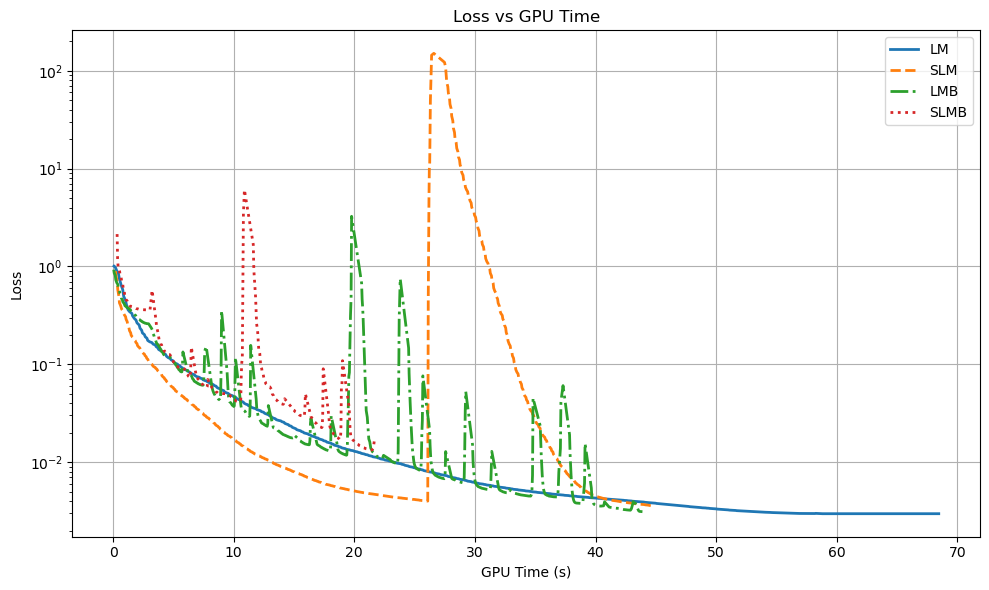

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],50, 50, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    optnum=3050
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=optnum, step=1000,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=optnum, step=1100,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=optnum, step=500,bd_tol=1,zone=3/4)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=optnum, step=1000,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 3050
[1] Reject
[2] Reject


<ipython-input-8-08b16a707594>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-8-08b16a707594>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[3] Accept | Loss = 2.044005 -> 1.140905 | parameter #: 3050| time: 149.1312713623047
[4] Accept | Loss = 1.140905 -> 1.001756 | parameter #: 3050| time: 227.346435546875
[5] Accept | Loss = 1.001756 -> 0.980749 | parameter #: 3050| time: 308.8988037109375
[6] Accept | Loss = 0.980749 -> 0.953425 | parameter #: 3050| time: 373.433349609375
[7] Accept | Loss = 0.953425 -> 0.901291 | parameter #: 3050| time: 449.259521484375
[8] Accept | Loss = 0.901291 -> 0.798086 | parameter #: 3050| time: 515.746826171875
[9] Reject
[10] Accept | Loss = 0.798086 -> 0.688634 | parameter #: 3050| time: 665.680908203125
[11] Reject
[12] Accept | Loss = 0.688634 -> 0.613147 | parameter #: 3050| time: 827.5691528320312
[13] Accept | Loss = 0.613147 -> 0.516630 | parameter #: 3050| time: 905.3685913085938
[14] Reject
[15] Accept | Loss = 0.516630 -> 0.463356 | parameter #: 3050| time: 1038.125
[16] Accept | Loss = 0.463356 -> 0.418641 | parameter #: 3050| time: 1087.689697265625
[17] Accept | Loss = 0.41864

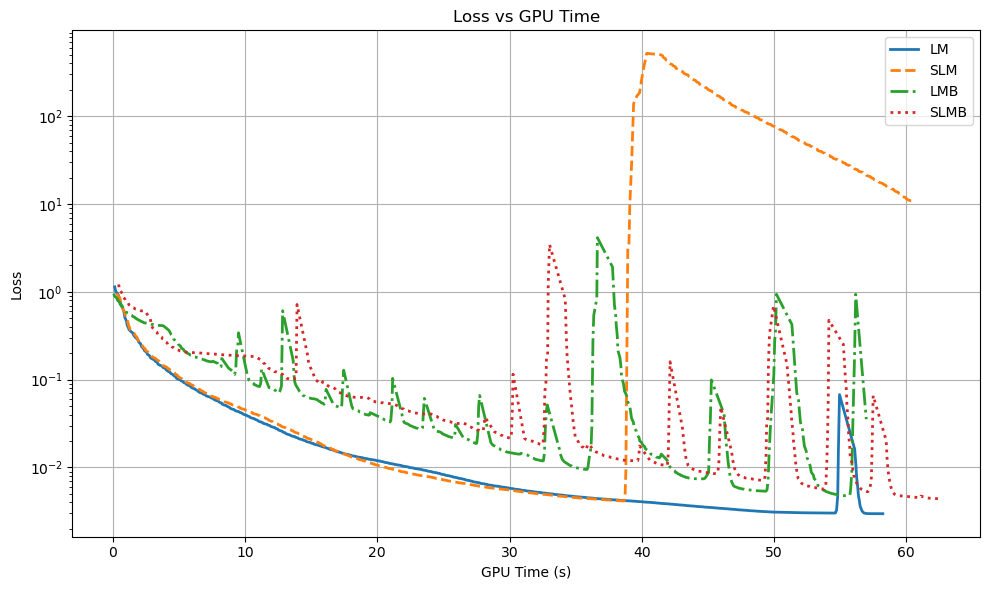

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],50, 50, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    optnum=3050
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=optnum, step=800,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=optnum, step=900,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=optnum, step=900,bd_tol=1,zone=3/4)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=optnum, step=800,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 3050
[1] Reject
[2] Accept | Loss = 1.326224 -> 1.013434 | parameter #: 3050| time: 82.79756927490234


<ipython-input-9-08b16a707594>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-9-08b16a707594>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[3] Accept | Loss = 1.013434 -> 0.990220 | parameter #: 3050| time: 151.74656677246094
[4] Accept | Loss = 0.990220 -> 0.961857 | parameter #: 3050| time: 243.704833984375
[5] Accept | Loss = 0.961857 -> 0.906956 | parameter #: 3050| time: 291.6648864746094
[6] Reject
[7] Accept | Loss = 0.906956 -> 0.852076 | parameter #: 3050| time: 460.9966125488281
[8] Accept | Loss = 0.852076 -> 0.752837 | parameter #: 3050| time: 529.8729248046875
[9] Reject
[10] Accept | Loss = 0.752837 -> 0.648631 | parameter #: 3050| time: 674.7739868164062
[11] Reject
[12] Accept | Loss = 0.648631 -> 0.581728 | parameter #: 3050| time: 862.8275146484375
[13] Accept | Loss = 0.581728 -> 0.499016 | parameter #: 3050| time: 936.4572143554688
[14] Reject
[15] Accept | Loss = 0.499016 -> 0.454440 | parameter #: 3050| time: 1079.762939453125
[16] Accept | Loss = 0.454440 -> 0.415304 | parameter #: 3050| time: 1171.45703125
[17] Accept | Loss = 0.415304 -> 0.388223 | parameter #: 3050| time: 1222.33544921875
[18] Ac

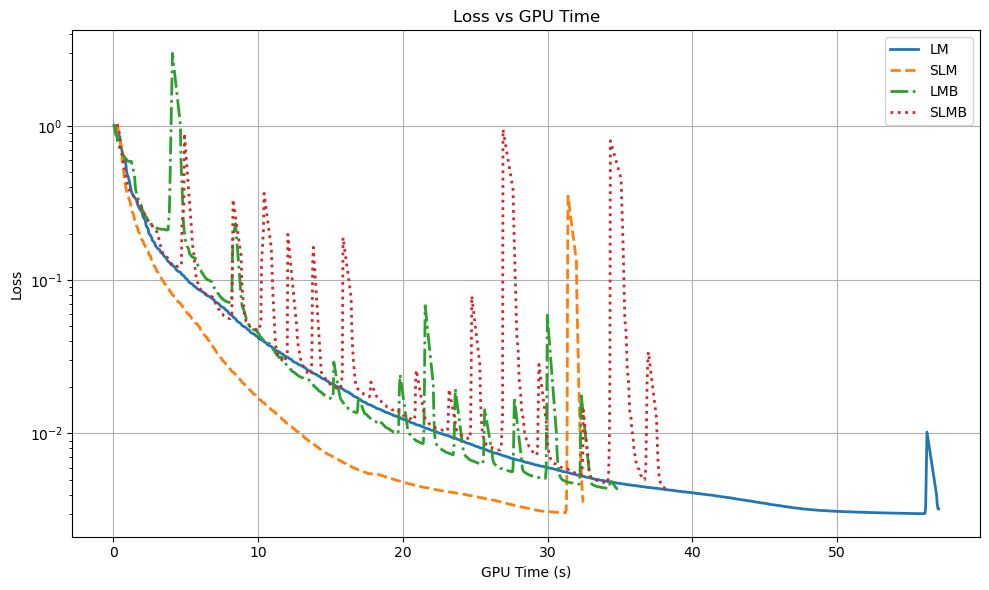

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],50, 50, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    optnum=3050
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=optnum, step=800,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=optnum, step=900,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=optnum, step=900,bd_tol=1,zone=3/4)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=optnum, step=800,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 3050
[1] Reject
[2] Reject


<ipython-input-10-0b0b036619ce>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-10-0b0b036619ce>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipyth

[3] Accept | Loss = 1.482525 -> 1.060258 | parameter #: 3050| time: 164.00588989257812
[4] Accept | Loss = 1.060258 -> 0.989835 | parameter #: 3050| time: 214.687744140625
[5] Accept | Loss = 0.989835 -> 0.976633 | parameter #: 3050| time: 261.6842346191406
[6] Accept | Loss = 0.976633 -> 0.957800 | parameter #: 3050| time: 326.3774719238281
[7] Accept | Loss = 0.957800 -> 0.920450 | parameter #: 3050| time: 422.67340087890625
[8] Accept | Loss = 0.920450 -> 0.840756 | parameter #: 3050| time: 517.8624267578125
[9] Reject
[10] Accept | Loss = 0.840756 -> 0.740660 | parameter #: 3050| time: 704.0040893554688
[11] Reject
[12] Accept | Loss = 0.740660 -> 0.663213 | parameter #: 3050| time: 800.4464721679688
[13] Accept | Loss = 0.663213 -> 0.552860 | parameter #: 3050| time: 846.2172241210938
[14] Reject
[15] Accept | Loss = 0.552860 -> 0.480921 | parameter #: 3050| time: 973.4533081054688
[16] Accept | Loss = 0.480921 -> 0.417561 | parameter #: 3050| time: 1069.6090087890625
[17] Accept 

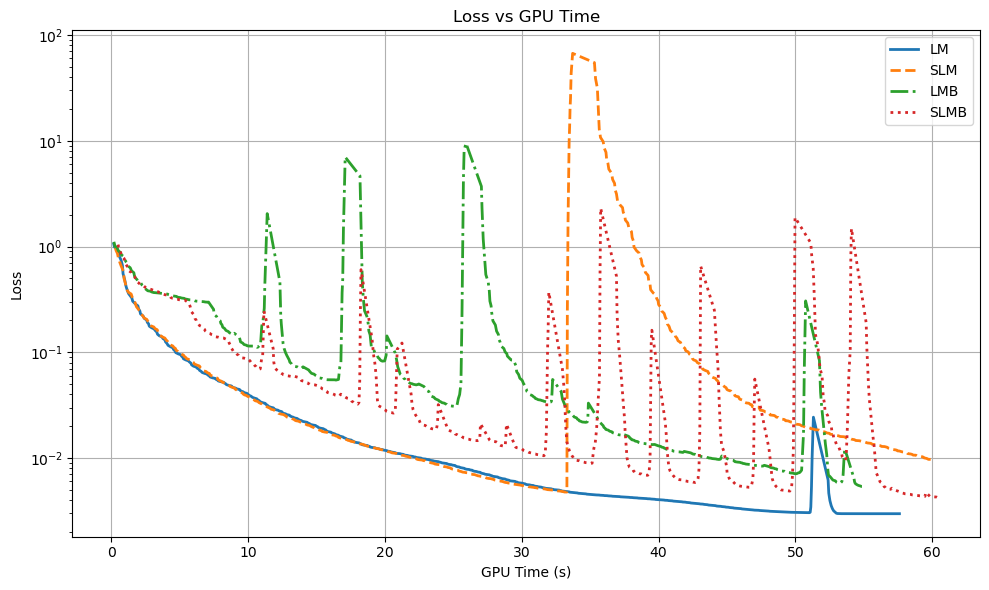

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],50, 50, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    optnum=3050
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=optnum, step=800,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=optnum, step=900,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=optnum, step=900,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=optnum, step=800,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 3050
[1] Reject
[2] Reject


<ipython-input-11-0939dc2a70f1>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-11-0939dc2a70f1>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipyth

[3] Accept | Loss = 1.439463 -> 1.041448 | parameter #: 3050| time: 179.6689910888672
[4] Accept | Loss = 1.041448 -> 0.974587 | parameter #: 3050| time: 247.7004852294922
[5] Accept | Loss = 0.974587 -> 0.961363 | parameter #: 3050| time: 293.5255126953125
[6] Accept | Loss = 0.961363 -> 0.941724 | parameter #: 3050| time: 339.9280700683594
[7] Accept | Loss = 0.941724 -> 0.901321 | parameter #: 3050| time: 385.7162170410156
[8] Accept | Loss = 0.901321 -> 0.811193 | parameter #: 3050| time: 463.7501525878906
[9] Reject
[10] Accept | Loss = 0.811193 -> 0.698625 | parameter #: 3050| time: 650.2123413085938
[11] Reject
[12] Accept | Loss = 0.698625 -> 0.617141 | parameter #: 3050| time: 837.1691284179688
[13] Accept | Loss = 0.617141 -> 0.510566 | parameter #: 3050| time: 883.1221923828125
[14] Reject
[15] Accept | Loss = 0.510566 -> 0.450870 | parameter #: 3050| time: 976.1546020507812
[16] Accept | Loss = 0.450870 -> 0.402875 | parameter #: 3050| time: 1049.608154296875
[17] Accept | 

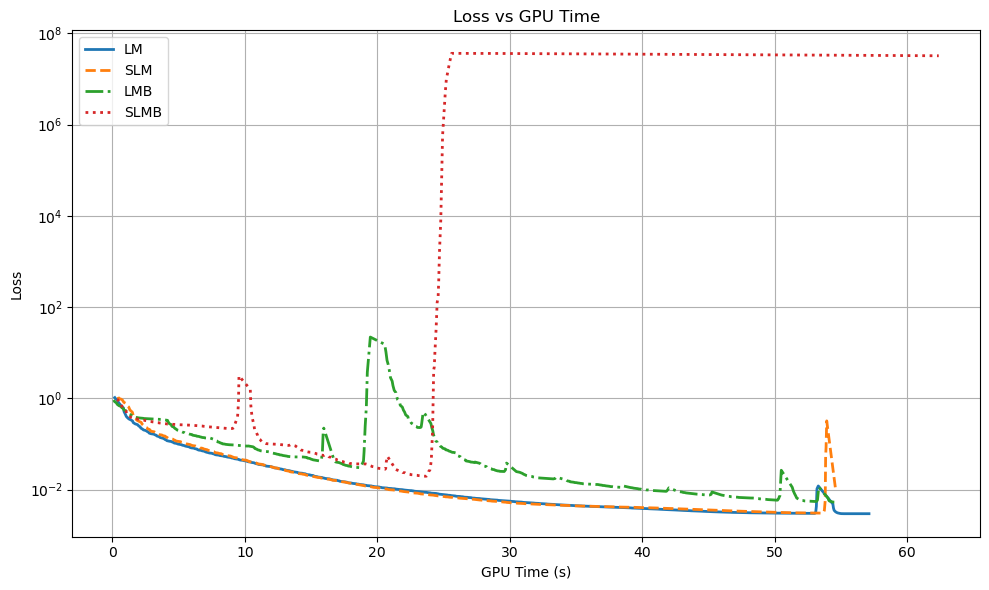

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],50, 50, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-10, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-10, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    optnum=3050
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=optnum, step=800,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=optnum, step=900,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=optnum, step=900,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=optnum, step=800,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 3050
[1] Reject
[2] Reject
[3] Accept | Loss = 1.665700 -> 1.090391 | parameter #: 3050| time: 101.285888671875


<ipython-input-12-0939dc2a70f1>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-12-0939dc2a70f1>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipyth

[4] Accept | Loss = 1.090391 -> 0.995682 | parameter #: 3050| time: 146.7975616455078
[5] Accept | Loss = 0.995682 -> 0.980417 | parameter #: 3050| time: 215.56736755371094
[6] Accept | Loss = 0.980417 -> 0.960250 | parameter #: 3050| time: 309.8439636230469
[7] Accept | Loss = 0.960250 -> 0.920750 | parameter #: 3050| time: 404.0202331542969
[8] Accept | Loss = 0.920750 -> 0.838423 | parameter #: 3050| time: 482.2906799316406
[9] Reject
[10] Accept | Loss = 0.838423 -> 0.739762 | parameter #: 3050| time: 635.5271606445312
[11] Reject
[12] Accept | Loss = 0.739762 -> 0.665525 | parameter #: 3050| time: 727.2908935546875
[13] Accept | Loss = 0.665525 -> 0.561511 | parameter #: 3050| time: 772.8547973632812
[14] Reject
[15] Accept | Loss = 0.561511 -> 0.493615 | parameter #: 3050| time: 961.0035400390625
[16] Accept | Loss = 0.493615 -> 0.430938 | parameter #: 3050| time: 1057.186767578125
[17] Accept | Loss = 0.430938 -> 0.391096 | parameter #: 3050| time: 1148.980224609375
[18] Reject


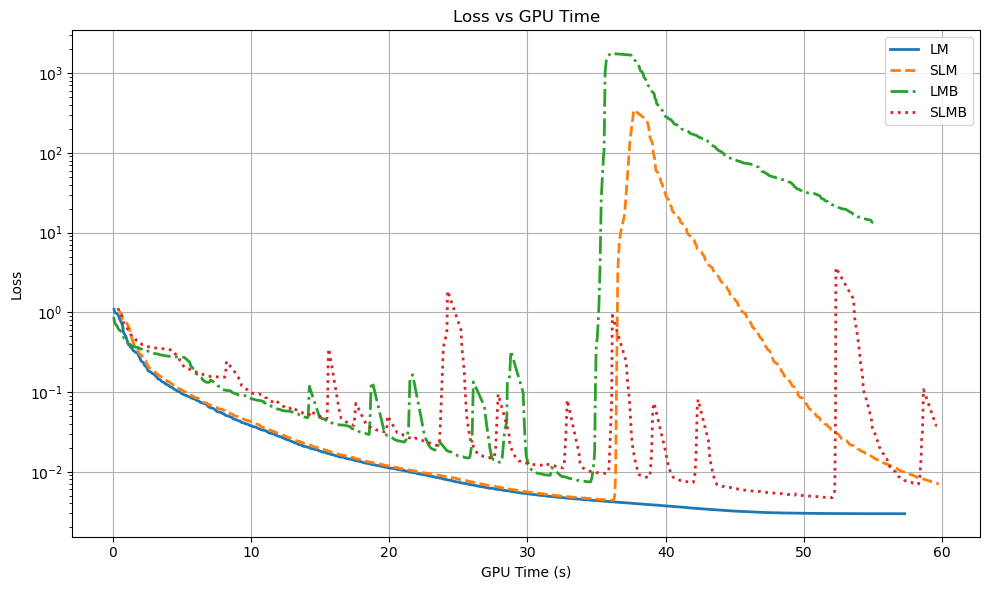

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],50, 50, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-10, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-10, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    optnum=3050
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=optnum, step=800,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=optnum, step=900,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=optnum, step=900,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=optnum, step=800,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 3050
[1] Reject
[2] Reject
[3] Accept | Loss = 1.739124 -> 1.065032 | parameter #: 3050| time: 104.6794204711914


<ipython-input-13-797372c4c7e1>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-13-797372c4c7e1>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipyth

[4] Accept | Loss = 1.065032 -> 0.960039 | parameter #: 3050| time: 151.12908935546875
[5] Accept | Loss = 0.960039 -> 0.942456 | parameter #: 3050| time: 197.3585968017578
[6] Accept | Loss = 0.942456 -> 0.917649 | parameter #: 3050| time: 301.0887756347656
[7] Accept | Loss = 0.917649 -> 0.867711 | parameter #: 3050| time: 395.1073303222656
[8] Accept | Loss = 0.867711 -> 0.763352 | parameter #: 3050| time: 487.0246276855469
[9] Reject
[10] Accept | Loss = 0.763352 -> 0.654816 | parameter #: 3050| time: 641.92919921875
[11] Reject
[12] Accept | Loss = 0.654816 -> 0.584685 | parameter #: 3050| time: 738.5303344726562
[13] Accept | Loss = 0.584685 -> 0.499487 | parameter #: 3050| time: 794.3331909179688
[14] Reject
[15] Accept | Loss = 0.499487 -> 0.454945 | parameter #: 3050| time: 964.0284423828125
[16] Accept | Loss = 0.454945 -> 0.417000 | parameter #: 3050| time: 1064.92724609375
[17] Accept | Loss = 0.417000 -> 0.390980 | parameter #: 3050| time: 1156.96435546875
[18] Accept | Lo

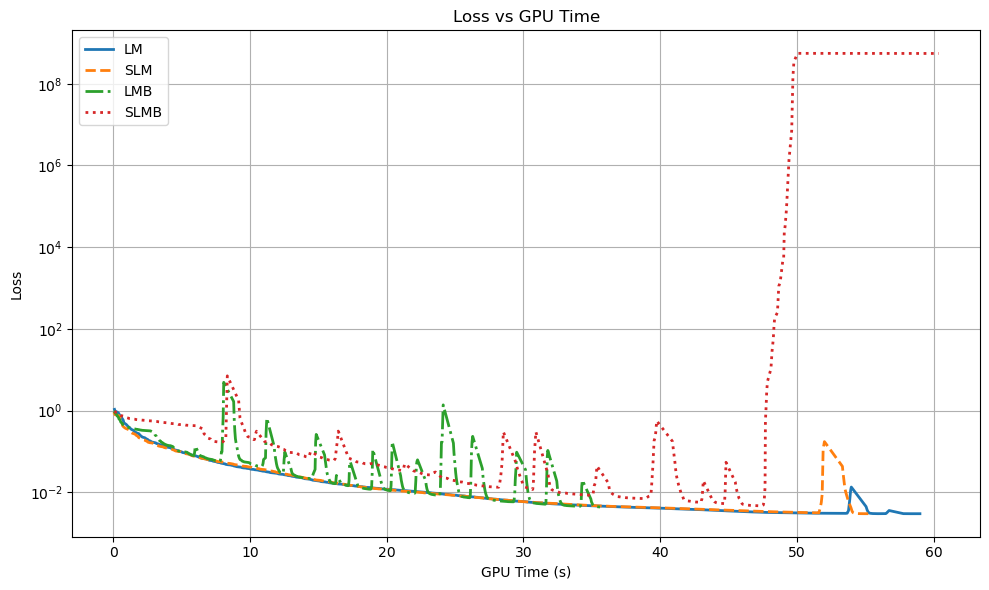

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],50, 50, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-10, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-10, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    optnum=3050
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=optnum, step=800,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=optnum, step=900,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=optnum, step=900,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=optnum, step=800,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 11100


<ipython-input-21-f082d222bc60>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-21-f082d222bc60>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipyth

[1] Accept | Loss = 1.040452 -> 0.965538 | parameter #: 11100| time: 0
[2] Accept | Loss = 0.965538 -> 0.905897 | parameter #: 11100| time: 558.287841796875
[3] Accept | Loss = 0.905897 -> 0.789921 | parameter #: 11100| time: 956.3658447265625
[4] Reject
[5] Reject
[6] Accept | Loss = 0.789921 -> 0.746525 | parameter #: 11100| time: 2298.0771484375
[7] Accept | Loss = 0.746525 -> 0.679170 | parameter #: 11100| time: 2866.53857421875
[8] Accept | Loss = 0.679170 -> 0.561699 | parameter #: 11100| time: 3448.14794921875
[9] Reject
[10] Accept | Loss = 0.561699 -> 0.487906 | parameter #: 11100| time: 4624.05322265625
[11] Accept | Loss = 0.487906 -> 0.426948 | parameter #: 11100| time: 5119.56982421875
[12] Accept | Loss = 0.426948 -> 0.393779 | parameter #: 11100| time: 5572.109375
[13] Accept | Loss = 0.393779 -> 0.374880 | parameter #: 11100| time: 5977.47314453125
[14] Reject
[15] Accept | Loss = 0.374880 -> 0.361173 | parameter #: 11100| time: 6964.71875
[16] Reject
[17] Accept | Loss

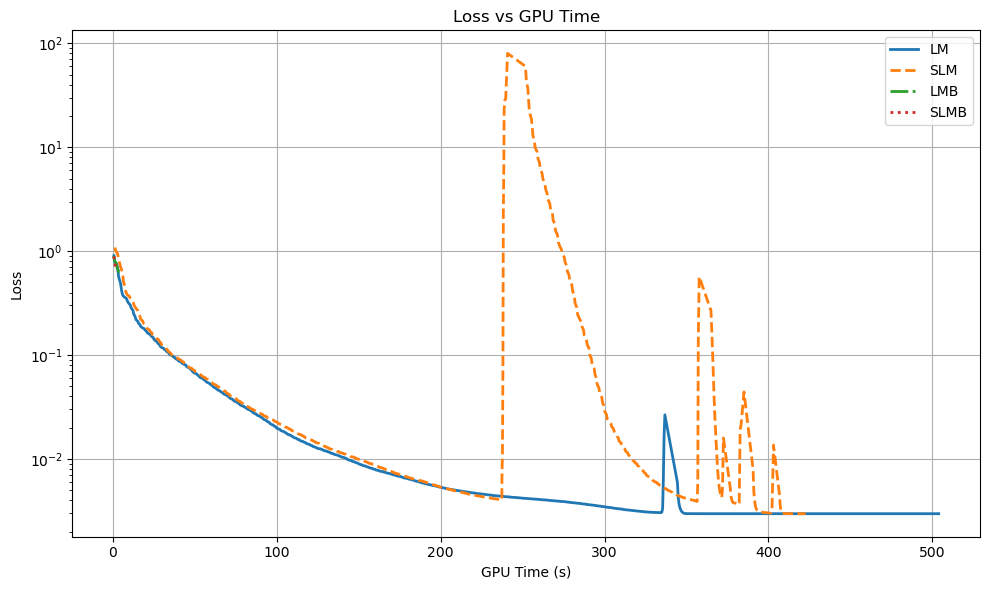

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],100, 100, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-7, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-7, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    optnum=11100
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=optnum, step=1000,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=optnum, step=1000,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=optnum, step=4,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=optnum, step=8,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 11100


<ipython-input-22-3ba0acb84150>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-22-3ba0acb84150>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipyth

[1] Reject
[2] Reject
[3] Reject
[4] Accept | Loss = 4.482895 -> 1.823474 | parameter #: 11100| time: 1214.6156005859375
[5] Accept | Loss = 1.823474 -> 1.113157 | parameter #: 11100| time: 1610.693603515625
[6] Accept | Loss = 1.113157 -> 1.032017 | parameter #: 11100| time: 2009.848876953125
[7] Accept | Loss = 1.032017 -> 1.017277 | parameter #: 11100| time: 2409.784423828125
[8] Accept | Loss = 1.017277 -> 0.994284 | parameter #: 11100| time: 2807.908447265625
[9] Accept | Loss = 0.994284 -> 0.951738 | parameter #: 11100| time: 3203.25732421875
[10] Accept | Loss = 0.951738 -> 0.873616 | parameter #: 11100| time: 3600.944091796875
[11] Reject
[12] Accept | Loss = 0.873616 -> 0.802039 | parameter #: 11100| time: 4392.5556640625
[13] Accept | Loss = 0.802039 -> 0.684506 | parameter #: 11100| time: 4792.369140625
[14] Reject
[15] Accept | Loss = 0.684506 -> 0.585016 | parameter #: 11100| time: 5590.431640625
[16] Reject
[17] Accept | Loss = 0.585016 -> 0.528870 | parameter #: 11100| t

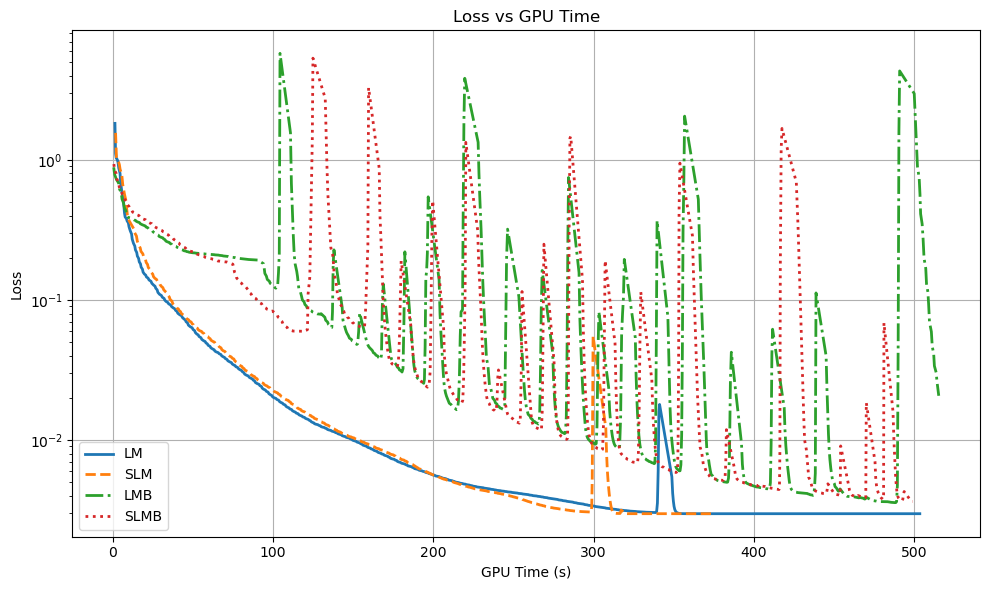

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],100, 100, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-7, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-7, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    optnum=11100
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=optnum, step=1000,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=optnum, step=1000,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=optnum, step=1000,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=optnum, step=1000,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

已重启 env-zqh (Python 3.11.0)

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 11100


<ipython-input-1-d635d0d21a7c>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-1-d635d0d21a7c>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[1] Accept | Loss = 1.110915 -> 0.989118 | parameter #: 11100| time: 0


<ipython-input-1-d635d0d21a7c>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-1-d635d0d21a7c>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)


[2] Accept | Loss = 0.989118 -> 0.934698 | parameter #: 11100| time: 727.6851196289062
[3] Accept | Loss = 0.934698 -> 0.832724 | parameter #: 11100| time: 1311.431640625
[4] Reject
[5] Reject
[6] Accept | Loss = 0.832724 -> 0.794277 | parameter #: 11100| time: 2750.593017578125
[7] Accept | Loss = 0.794277 -> 0.733297 | parameter #: 11100| time: 3200.19775390625
[8] Accept | Loss = 0.733297 -> 0.616410 | parameter #: 11100| time: 3704.942626953125
[9] Reject
[10] Accept | Loss = 0.616410 -> 0.529936 | parameter #: 11100| time: 4886.62109375
[11] Accept | Loss = 0.529936 -> 0.452270 | parameter #: 11100| time: 5470.91455078125
[12] Reject
[13] Accept | Loss = 0.452270 -> 0.424863 | parameter #: 11100| time: 6547.99560546875
[14] Accept | Loss = 0.424863 -> 0.406006 | parameter #: 11100| time: 6991.67236328125
[15] Accept | Loss = 0.406006 -> 0.390934 | parameter #: 11100| time: 7421.685546875
[16] Reject
[17] Accept | Loss = 0.390934 -> 0.382289 | parameter #: 11100| time: 8409.2021484

<ipython-input-1-d635d0d21a7c>:103: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647369228/work/aten/src/ATen/native/TensorShape.cpp:3683.)
  correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)


[2] Accept | Loss = 0.973133 -> 0.925751 | parameter #: 11100| time: 541.507568359375
[3] Accept | Loss = 0.925751 -> 0.845836 | parameter #: 11100| time: 1052.5081787109375
[4] Reject
[5] Accept | Loss = 0.845836 -> 0.799662 | parameter #: 11100| time: 1985.033203125
optnumber 11100
[6] Accept | Loss = 0.799662 -> 0.724673 | parameter #: 11100| time: 2421.200927734375
[7] Reject
[8] Accept | Loss = 0.724673 -> 0.682706 | parameter #: 11100| time: 3363.187744140625
[9] Reject
[10] Accept | Loss = 0.682706 -> 0.657747 | parameter #: 11100| time: 4541.5771484375
optnumber 11100
[11] Accept | Loss = 0.657747 -> 0.615647 | parameter #: 11100| time: 5115.18505859375
[12] Reject
[13] Accept | Loss = 0.615647 -> 0.591333 | parameter #: 11100| time: 6152.9765625
[14] Accept | Loss = 0.591333 -> 0.551965 | parameter #: 11100| time: 6627.115234375
[15] Reject
[16] Accept | Loss = 0.551965 -> 0.530015 | parameter #: 11100| time: 7506.720703125
[17] Accept | Loss = 0.530015 -> 0.496224 | parameter

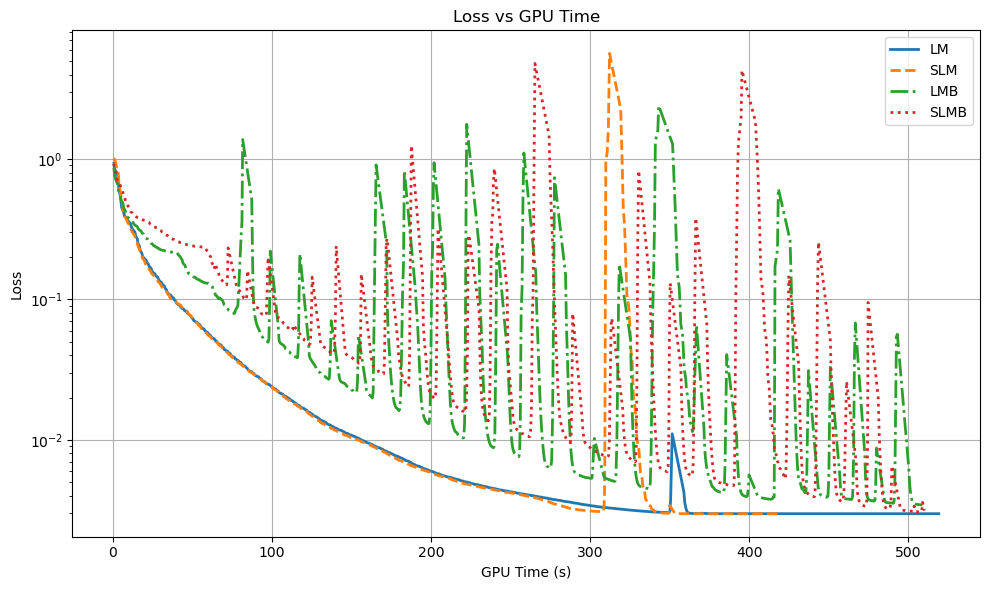

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],100, 100, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-7, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 3, 0.5
        yi, yi2 = 1e-7, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    optnum=11100
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=optnum, step=1000,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=optnum, step=1050,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=optnum, step=1000,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=optnum, step=1000,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

没有连接的内核